<center>
<h1> Assignment 4 </h1>
</center>

## Question 1
Cross-dispatch requests might make querying Uber's data complicated in th following ways: <ul><li> If a user tries to query the number of vehicles or people deployed for each of the categories viz. UberX, UberXL, UberBlack, based on the segregation of the rides by category segments, he may overcount the number of people in these categories since there may be people who are cross listed in two or more categories. This may, in turn, distort other average metrics such as average login time by category, average earnings and so on.
<li> At any given time, the number of cars available in each neighborhood in each category may be calculated by the real-time location of non-occupied cars in each respective category. However, Cross-Dispatch may lead to estimation errors since some category may have additional vehicles that can potentially be assigned from other categories to those categories (UberBlack assigned for an UberX ride, for instance), while some categories would have lesser number of vehicles than estimated (since an UberBlack could have been assigned to an UberX ride and is hence no longer available for an UberBlack ride in an area). This may lead to poor scheduling and surge pricing in some cases.

## Question 2
The query for the number of trips completed by week for the weeks of March, 2014, for each driver in New York City is:

<b>select driver_id, extract(week from req_at) as week, count(*) from trips <br>
inner join cities on cities.id = trips.city_id<br>
where name = 'New York' and extract(month from requests_at) == 3 and extract(year from requests_at) == 2014 and<br>
status == 'completed' groupby driver_id, extract(week from requests_at)</b>

## Question 3
The counts of drivers and supply hours are inflated due to cross-dispatch. Since a driver can be allotted to rides spanning across the categories of UberX, UberXL, UberBlack and so on, The same driver is counted two or more time: once for each category that he was allocated a ride for. Thus, a driver who did at least one UberX, UberXL and UberBlack ride would be counted as 3 drivers since he is listed under each category and we are summing the drivers by category.

This, in turn would result in overcounting their supply hours. Taking the above example, a driver who did at least one UberX, UberXL and UberBlack ride, and was online for 8 hours, would have 24 supply hours based on the query given: 8 for each category that his name appeared under.

Owing to the above reasons, while the aggregate_fares would remain unaffected (since they are based on the actual fare of the trip, independent of the number of drivers listed under each category), the average_fares_per_hour would be less than the actual value for average_fares_per_hour since we discussed above that the driver hours are getting overcounted, and hence average_fares_per_hour: fares/total_hours, would have a lower value than the actual one. For example, assuming we have only one driver in the Uber network and he made a total of \$200 in 8 hours across the three categories discussed above. While the actual value for average_fare_per_hour would be 200/8 which is \$25/hour, the value counted using the given query would be 200/24, which is \$8.33/hour: 1/3rd of the actual value.

Another mistake in the query is that it does not take explicit float type cast for division-based calculations, which may lead to overcounting or undercounting, depending on the metric we are calculating using this division result. Each value calculated without explicit typecast to float would round down the results to the nearest integer.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from pandas import DatetimeIndex

## Analysis Test
### Genrating the graph showing the long-term trend of logins in the city.

In [2]:
data = pd.read_json("logins.json")
data.columns = ['datetime']

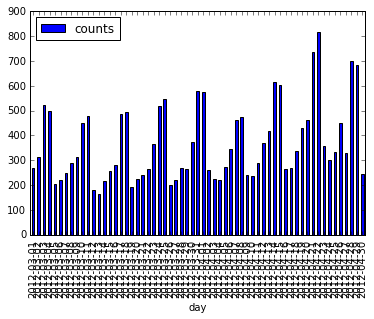

In [3]:
data['day'] = data['datetime'].apply(lambda x: str(x)[0:10])
databyday = dict(data[['day']].groupby('day')['day'].count())
databyday = pd.DataFrame(list(databyday.items()), columns = ['day','counts'])
databyday = databyday.sort_values(by = 'day')
plottrends = databyday[['day', 'counts']].plot(x='day', kind='bar')
plt.show()

The graph shows a more-or-less upward trend as we go from 2012-03-01 to 2012-04-30.

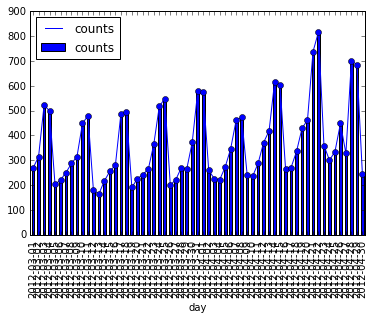

In [4]:
ax = databyday[['day', 'counts']].plot(x='day', linestyle='-', marker='o')
databyday[['day','counts']].plot(x='day', kind='bar', ax = ax )

plt.show()

### Fitting the above plot to a best fit line, represented by a cubic polynomial.

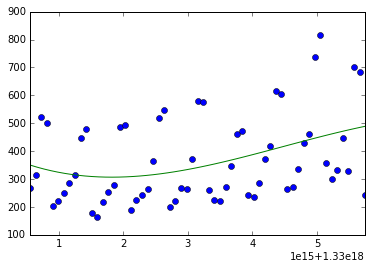

In [5]:
databyday['day'] = pd.to_datetime(databyday['day']).astype('int64')
X = np.array(databyday.day)
Y = np.array(databyday.counts)

z = np.polyfit(X, Y, 3)
f = np.poly1d(z)

x_new = np.linspace(X[0], X[-1], 50)
y_new = f(x_new)

plt.plot(X,Y,'o', x_new, y_new)
plt.xlim([X[0]-1, X[-1] + 1 ])
plt.show()

Thus, as we see, the data cn be explained by a cubic polynomial and shows a curved trend.

It is highly unlikely for a person aged 123 to shop online. Hence, this gives us an indication that there may be outliers in our data. We explore more about these outliers by plotting the ages using matplotlib's pyplot.

### Trends
We notice that the graph shows a weekly upward trend, that is, the customer logins increase as we go from Monday to Sunday, and then drops again significantly on Monday. This trend repeats more or less over every week. We can further verify this using the graph by days of the week in the following section.

### Generating Graphs by days of the week and hour of the day.

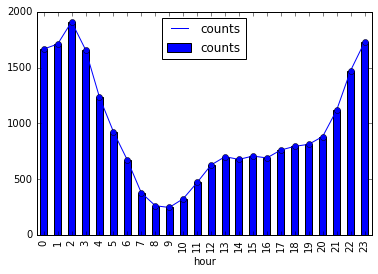

In [6]:
data['datetime'] = pd.to_datetime(data.datetime)
data['hour'] = data['datetime'].apply (lambda x: str(x)[11:13])
databytime = dict(data[['hour']].groupby('hour')['hour'].count())
databytime = pd.DataFrame(list(databytime.items()), columns = ['hour','counts'])
databytime['hour'] = databytime['hour'].astype(int)
databytime = databytime.sort_values(by = 'hour')
databytime
ax = databytime[['hour', 'counts']].plot(x='hour', linestyle='-', marker='o')
databytime[['hour','counts']].plot(x='hour', kind='bar', ax = ax )

plt.show()

The data shows an increasing trend between 0 to 2 hours, followed by a steep drop until 8 hours. The graph then increases non-uniformly until 21 hours and then steeply increases until 23 hours.

This can be explained as: The night times from 21 hours to 02 hours (9 PM to 2 AM) are marked by party hours and hence, people login to the app since they are usually drunk at this time and prefer to take a cab back home, both for health and legal reasons. The app logins dicrease after 2 AM and drop to a minimum until 8 AM. Following this, people book cabs for their office commute and other miscellaneous reasons and this only increases non-uniformly until 16 hours (4 PM), following which it increases exponentially due to the commute from office coupled with the miscellaneous social activities in all age groups, and this slowly merges into the party time until 21 hours (9 PM), thus accounting for the increase. We also look at the best fit curve to validate our analysis.

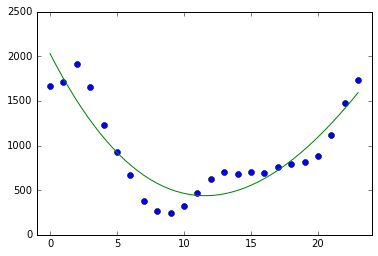

In [7]:
X = np.array(databytime.hour)
Y = np.array(databytime.counts)

z = np.polyfit(X, Y, 3)
f = np.poly1d(z)

x_new = np.linspace(X[0], X[-1], 50)
y_new = f(x_new)

plt.plot(X,Y,'o', x_new, y_new)
plt.xlim([X[0]-1, X[-1] + 1 ])
plt.show()

#### As we can see, the cubic polynomial best fit line agrees with the trend discussed above.

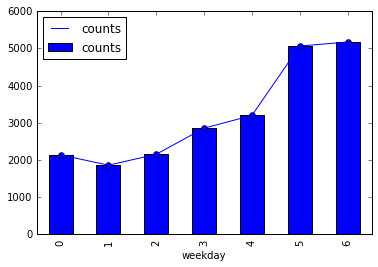

In [8]:
data['weekday'] = data['datetime'].dt.dayofweek
databyweekday = dict(data[['weekday']].groupby('weekday')['weekday'].count())
databyweekday = pd.DataFrame(list(databyweekday.items()), columns = ['weekday','counts'])
databyweekday = databyweekday.sort_values(by = 'weekday')
ax = databyweekday[['weekday', 'counts']].plot(x='weekday', linestyle='-', marker='o')
databyweekday[['weekday','counts']].plot(x='weekday', kind='bar', ax = ax )

plt.show()

As we can see, and support our observation above, the traffic increases from Monday to Sunday more or less uniformly, with a rather slight quadratic upward trend. This can be explained by the fact that people tend to party and go out more over the weekends and hence, the number of customer app logins increases. The trends is gradual from Monday to Sunday, which can be explained by the fact that people tend to come into the "party and relax" mode as we approach towards the weekend, and consequently, have an increasing trend of engaging in social activities across multiple locations as they progress through the week from Monday to Sunday. We also look at the best curve to validate our analysis.

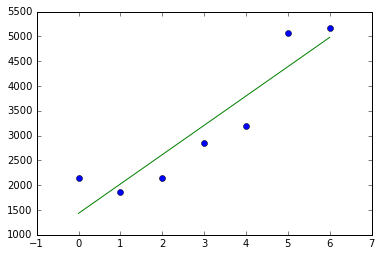

In [9]:
X = np.array(databyweekday.weekday)
Y = np.array(databyweekday.counts)

z = np.polyfit(X, Y, 1)
f = np.poly1d(z)

x_new = np.linspace(X[0], X[-1], 50)
y_new = f(x_new)

plt.plot(X,Y,'o', x_new, y_new)
plt.xlim([X[0]-1, X[-1] + 1 ])
plt.show()

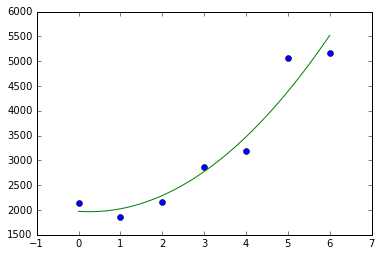

In [10]:
X = np.array(databyweekday.weekday)
Y = np.array(databyweekday.counts)

z = np.polyfit(X, Y, 2)
f = np.poly1d(z)

x_new = np.linspace(X[0], X[-1], 50)
y_new = f(x_new)

plt.plot(X,Y,'o', x_new, y_new)
plt.xlim([X[0]-1, X[-1] + 1 ])
plt.show()

#### As we can see, the graph is better approximated by a quadtraic curve than a straight line. The curve validates our analysis for login trends by days of the week.